In [1]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np
import glob
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def plotPoke(x, n_row=10):
    f, a = plt.subplots(2, n_row, figsize=(n_row, 2))
    for i in range(n_row):
        a[0][i].imshow(x[i])
        a[0,i].axis('off')
        a[1][i].imshow(x[i+n_row])
        a[1,i].axis('off')
    f.show()
    plt.draw()

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


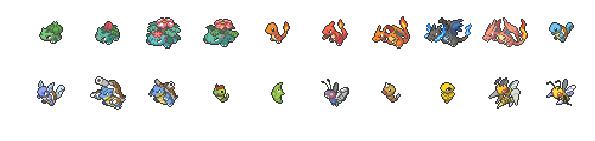

In [3]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40, 3), dtype='uint8')
# Load all images and append into orig_img
path = os.path.abspath("./PixelRNN.ipynb")
path = re.sub('[a-zA-Z\s.]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
plotPoke(orig_img)

In [4]:
# Parameters
learning_rate = 0.0001
training_epochs = 10
batch_size = 12
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = 3 # Pokemon data input (img shape: 1 pixel RGB)
n_steps = 40*13 # timesteps (40 pixels a rows, given 13 rows)
n_hidden = 256 # hidden layer num of features

# tf Graph input
X = tf.placeholder("float", [None, n_steps, n_input])
Y = tf.placeholder("float", [None, n_input])

# Define weights
weights = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_input], stddev=0.01))
}
biases = {
    'out': tf.Variable(tf.truncated_normal([n_input], stddev=0.01))
}

In [5]:
def RNN(x, weights, biases):
    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Permuting batch_size and n_steps (n_step, batch_size, n_input)
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=0.1)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(X, weights, biases)
true = Y
# Define loss and optimizer
cost = tf.sqrt(tf.reduce_mean(tf.pow(true - pred, 2)))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [6]:
# Initializing the variables
init = tf.global_variables_initializer()

# Create session and graph, initial variables
sess = tf.InteractiveSession()
sess.run(init)

In [7]:
# Load previous trained model and rewrite to variables, if exists
# Before run this cell, you have to run the cell above first, to define variables and init it.
weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)

weightSaver.restore(sess, "./saved_model/RNN_weights.ckpt")
biaseSaver.restore(sess, "./saved_model/RNN_biases.ckpt")

print "Model restored."

Model restored.


In [ ]:
total_batch = int(orig_img.shape[0]/batch_size)
# Training cycle
for epoch in xrange(training_epochs):
    # Loop over all batches
    start = 0; end = batch_size
    for i in range(total_batch-1):
        index = np.arange(start, end)
        np.random.shuffle(index)
        for num_pixel in xrange(n_steps**2-n_steps):
            # Run optimization op (backprop) and loss op (to get loss value)
            startIndex = num_pixel
            endIndex = num_pixel+n_steps            
            train = orig_img[index,:,:,:].reshape((batch_size, -1, 3))
            batch_x = train[:,startIndex:endIndex,:].reshape((batch_size, n_steps, n_input))
            batch_y = train[:,endIndex,:].reshape((batch_size, n_input))
            
            # Run optimization op (backprop) and loss op (to get loss value)
            sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y})
            loss = sess.run(cost, feed_dict={X: batch_x, Y: batch_y})
        start = end; end = start+batch_size
    # Display logs per epoch step
    if ((epoch == 0) or (epoch+1) % display_step == 0) or ((epoch+1) == training_epochs):
        print 'Epoch: {0:04d}   loss: {1:f}'.format(epoch+1, loss)

print("Optimization Finished!")

In [14]:
index = np.random.randint(orig_img.shape[0], size=examples_to_show)
fakePoke = orig_img[index,0,:,:].reshape((examples_to_show, 40, 3))
for i in xrange(40*39):
    startIndex = i
    endIndex = i+n_steps
    train = fakePoke[:,startIndex:endIndex,:].reshape((examples_to_show, n_steps, n_input))
    PixelRNN = sess.run(pred, feed_dict={X: train})
    PixelRNN = PixelRNN.reshape((examples_to_show,1,3))
    fakePoke = np.concatenate((fakePoke, PixelRNN), axis=1)
    
# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(orig_img[index[i]])
    a[0,i].axis('off')
    a[1][i].imshow(fakePoke[i])
    a[1,i].axis('off')
f.show()
plt.draw()

0 40
(10, 1, 3)
(10, 40, 3)
(10, 41, 3)
1 41
(10, 1, 3)
(10, 41, 3)
(10, 42, 3)
2 42
(10, 1, 3)
(10, 42, 3)
(10, 43, 3)
3 43
(10, 1, 3)
(10, 43, 3)
(10, 44, 3)
4 44
(10, 1, 3)
(10, 44, 3)
(10, 45, 3)
5 45
(10, 1, 3)
(10, 45, 3)
(10, 46, 3)
6 46
(10, 1, 3)
(10, 46, 3)
(10, 47, 3)
7 47
(10, 1, 3)
(10, 47, 3)
(10, 48, 3)
8 48
(10, 1, 3)
(10, 48, 3)
(10, 49, 3)
9 49
(10, 1, 3)
(10, 49, 3)
(10, 50, 3)
10 50
(10, 1, 3)
(10, 50, 3)
(10, 51, 3)
11 51
(10, 1, 3)
(10, 51, 3)
(10, 52, 3)
12 52
(10, 1, 3)
(10, 52, 3)
(10, 53, 3)
13 53
(10, 1, 3)
(10, 53, 3)
(10, 54, 3)
14 54
(10, 1, 3)
(10, 54, 3)
(10, 55, 3)
15 55
(10, 1, 3)
(10, 55, 3)
(10, 56, 3)
16 56
(10, 1, 3)
(10, 56, 3)
(10, 57, 3)
17 57
(10, 1, 3)
(10, 57, 3)
(10, 58, 3)
18 58
(10, 1, 3)
(10, 58, 3)
(10, 59, 3)
19 59
(10, 1, 3)
(10, 59, 3)
(10, 60, 3)
20 60
(10, 1, 3)
(10, 60, 3)
(10, 61, 3)
21 61
(10, 1, 3)
(10, 61, 3)
(10, 62, 3)
22 62
(10, 1, 3)
(10, 62, 3)
(10, 63, 3)
23 63
(10, 1, 3)
(10, 63, 3)
(10, 64, 3)
24 64
(10, 1, 3)
(10, 64, 

In [ ]:
# Save trained Variables 
weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)
save_path = weightSaver.save(sess, "./saved_model/RNN_weights.ckpt")
save_path = biaseSaver.save(sess, "./saved_model/RNN_biases.ckpt")

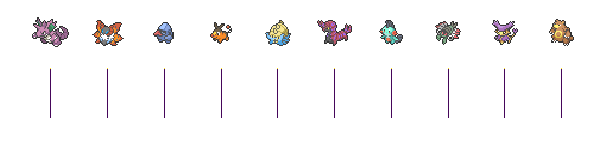

In [15]:
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(orig_img[index[i]])
    a[0,i].axis('off')
    a[1][i].imshow(fakePoke[i])
    a[1,i].axis('off')
f.show()
plt.draw()

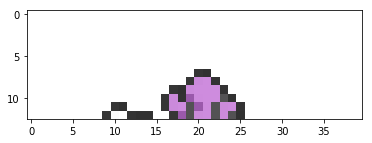

In [33]:
plt.imshow(orig_img[np.random.randint(700),:13,:,:])